In [1]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import h5py
from matplotlib.path import Path
from scipy.spatial import cKDTree as KDTree
import pandas as pd 
import sectionate as sec
import regionate as reg
from xgcm import Grid
%matplotlib inline

In [2]:
# Import u,v, theta for January 1st, 2007. Testing for a single time step. 

os.chdir('/data/globus/zkaufman')

UVEL_fulldepth = xr.open_dataset('UVEL_SoHi_JFM_daily.nc').UVEL.isel(date=0)
VVEL_fulldepth = xr.open_dataset('VVEL_SoHi_JFM_daily.nc').VVEL.isel(date=0)
THETA_fulldepth = xr.open_dataset('THETA_SoHi_JFM_daily.nc').THETA.isel(date=0)

# adjust longitude conventions to 0-360 

def _to360(lon):
    return np.mod(lon, 360.0)

UVEL_fulldepth = UVEL_fulldepth.assign_coords(lon=_to360(UVEL_fulldepth.lon)).sortby("lon")
VVEL_fulldepth = VVEL_fulldepth.assign_coords(lon=_to360(VVEL_fulldepth.lon)).sortby("lon")
THETA_fulldepth = THETA_fulldepth.assign_coords(lon=_to360(THETA_fulldepth.lon)).sortby("lon")


ds = xr.Dataset(
    dict(
        UVEL=UVEL_fulldepth,
        VVEL=VVEL_fulldepth,
        THETA=THETA_fulldepth
    )
)


# note that horiz. coordinates are not labeled with C-grid center/edges. 
ds 

<xarray.Dataset> Size: 59GB
Dimensions:  (lat: 2541, depth: 225, lon: 8640)
Coordinates:
    date     float32 4B 1.051e+06
  * lat      (lat) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
  * depth    (depth) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
  * lon      (lon) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
Data variables:
    UVEL     (depth, lat, lon) float32 20GB ...
    VVEL     (depth, lat, lon) float32 20GB ...
    THETA    (depth, lat, lon) float32 20GB ...

In [11]:
# add SOhi grid coordinates 

grid = '/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/GRID_v8.mat'
grid = h5py.File(grid, 'r')

# longitudes 

XC = grid['XC'][0,:]  # center 
DXC = grid['DXC'][0,:] 

XG = grid['XG'][0,:] # edge 
DXG = grid['DXG'][0,:]

# latitudes 

YC = grid['YC'][:2541,0]
DYC = grid['DYC'][:2541,0]

YG = grid['YG'][:2541,0]
DYG = grid['DYG'][:2541,0]

# vertical cells 

RC = grid['RC'][0,:]
DRC = grid['DRC'][0,:]

RF = grid['RF'][0,:]
DRF = grid['DRF'][0,:]

ds = ds.assign_coords(
    XC=("XC", XC),
    DXC=("XC", DXC),
    XG=("XG", XG),
    DXG=("XG", DXG),
    YC=("YC", YC),
    DYC=("YC", DYC),
    YG=("YG", YG),
    DYG=("YG", DYG),
    RC=("RC", RC),
    DRC=("RF", DRC),
    RF=("RF", RF),
    DRF=("RC", DRF)
)




In [14]:
ds

<xarray.Dataset> Size: 59GB
Dimensions:  (lat: 2541, depth: 225, lon: 8640, XC: 8640, XG: 8640, YC: 2541,
              YG: 2541, RC: 225, RF: 226)
Coordinates: (12/16)
    date     float32 4B 1.051e+06
  * lat      (lat) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
  * depth    (depth) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
  * lon      (lon) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
  * XC       (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC      (XC) float32 35kB 363.8 363.8 363.8 363.8 ... 363.8 363.8 363.8
    ...       ...
  * YG       (YG) float32 10kB -85.5 -85.49 -85.48 ... -50.08 -50.05 -50.03
    DYG      (YG) float32 10kB 999.8 999.8 999.8 ... 2.975e+03 2.977e+03
  * RC       (RC) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
    DRC      (RF) float32 904B 0.7 1.418 1.453 1.489 ... 50.0 50.0 50.0 25.0
  * RF       (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF      (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0 50.0
Data variables:
    UVEL     (depth, lat, lon) float32 20GB ...
    VVEL     (depth, lat, lon) float32 20GB ...
    THETA    (depth, lat, lon) float32 20GB ...

In [15]:
# Adjust U,V,theta coords. to appropriate C-grid conventions (subset to poleward of 50 deg. S) 

def _remap_with_coords(da, dim_map, coord_map):
    """
    da: DataArray to remap
    dim_map: {'old_dim': 'new_dim', ...}
    coord_map: {'new_dim': <Coord DataArray or 1D np.array>, ...}
    """
    out = da.rename(dim_map)
    # ensure sizes line up, then attach the target coordinate VALUES
    for newdim, coord in coord_map.items():
        if out.sizes[newdim] != coord.size:
            raise ValueError(
                f"Size mismatch for {newdim}: data has {out.sizes[newdim]}, "
                f"coord has {coord.size}"
            )
        out = out.assign_coords({newdim: (newdim, np.asarray(coord))})
    return out

# UVEL -> (YC, XG)
ds["UVEL"] = _remap_with_coords(
    ds["UVEL"],
    dim_map={"depth": "RC","lat": "YC", "lon": "XG"},
    coord_map={"RC": ds["RC"],"YC": ds["YC"], "XG": ds["XG"]},
)

# VVEL -> (YG, XC)
ds["VVEL"] = _remap_with_coords(
    ds["VVEL"],
   dim_map={"depth": "RC","lat": "YG", "lon": "XC"},
    coord_map={"RC": ds["RC"],"YG": ds["YG"], "XC": ds["XC"]},
)

# THETA -> (YC, XC)
ds["THETA"] = _remap_with_coords(
    ds["THETA"],
    dim_map={"depth": "RC","lat": "YC", "lon": "XC"},
    coord_map={"RC": ds["RC"],"YC": ds["YC"], "XC": ds["XC"]},
)

# Optional: drop any leftover old coordinate variables
ds = ds.drop_vars(["depth","lat", "lon"], errors="ignore")

# see that ds adjusted correctly  
ds

<xarray.Dataset> Size: 59GB
Dimensions:  (RC: 225, YC: 2541, XG: 8640, YG: 2541, XC: 8640, RF: 226)
Coordinates: (12/13)
    date     float32 4B 1.051e+06
  * XC       (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC      (XC) float32 35kB 363.8 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XG       (XG) float32 35kB 0.0 0.04167 0.08333 0.125 ... 359.9 359.9 360.0
    DXG      (XG) float32 35kB 363.5 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC       (YC) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
    ...       ...
  * YG       (YG) float32 10kB -85.5 -85.49 -85.48 ... -50.08 -50.05 -50.03
    DYG      (YG) float32 10kB 999.8 999.8 999.8 ... 2.975e+03 2.977e+03
  * RC       (RC) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
    DRC      (RF) float32 904B 0.7 1.418 1.453 1.489 ... 50.0 50.0 50.0 25.0
  * RF       (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF      (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0 50.0
Data variables:
    UVEL     (RC, YC, XG) float32 20GB ...
    VVEL     (RC, YG, XC) float32 20GB ...
    THETA    (RC, YC, XC) float32 20GB ...

In [16]:
# obtain bathymetry and cell area 

bathym_on_uv = xr.open_dataset("bathym_on_uv.nc").bathymetry 
areacello = xr.open_dataset('SOhi.static.nc').area

# adjust coordinates, as previously done with U,V,Theta 

ds["deptho_on_uv"] = \
xr.DataArray(bathym_on_uv.values, dims=("YG", "XG")).ffill("XG").bfill("XG").ffill("YG").bfill("YG")

# since cell area has a more poleward northern boundary, we need to trim the rest of the dataset accordingly. 

n_target = areacello.sizes['lat']
ds = ds.isel(
    YG=slice(0, n_target),
    YC=slice(0, n_target),
)

ds["areacello"] = \
xr.DataArray(areacello.values, dims=("YC", "XC")).ffill("XC").bfill("XC").ffill("YC").bfill("YC")


ds


<xarray.Dataset> Size: 55GB
Dimensions:       (RC: 225, YC: 2344, XG: 8640, YG: 2344, XC: 8640, RF: 226)
Coordinates: (12/13)
    date          float32 4B 1.051e+06
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XG            (XG) float32 35kB 0.0 0.04167 0.08333 ... 359.9 359.9 360.0
    DXG           (XG) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC            (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.05 -55.03 -55.0
    ...            ...
  * YG            (YG) float32 9kB -85.5 -85.49 -85.48 ... -55.06 -55.04 -55.02
    DYG           (YG) float32 9kB 999.8 999.8 999.8 ... 2.655e+03 2.657e+03
  * RC            (RC) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
    DRC           (RF) float32 904B 0.7 1.418 1.453 1.489 ... 50.0 50.0 25.0
  * RF            (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF           (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0
Data variables:
    UVEL          (RC, YC, XG) float32 18GB ...
    VVEL          (RC, YG, XC) float32 18GB ...
    THETA         (RC, YC, XC) float32 18GB ...
    deptho_on_uv  (YG, XG) float32 81MB 0.0 0.0 0.0 ... 1.871e+03 1.871e+03
    areacello     (YC, XC) float32 81MB 3.638e+05 3.638e+05 ... 7.059e+06

In [17]:

# The commented out xgcm grid won't work because regionate only accomodates "center" "outer labels"

#coords={'X': {'center': 'XC', 'left': 'XG'},
                        #'Y': {'center': 'YC', 'left': 'YG'}}
#boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
#grid = Grid(ds,coords=coords,boundary=boundary,autoparse_metadata=False)
#grid


# so we make the grid digestible for regionate following Henri Drake's proof of concept 

ds_xouter = xr.concat([
    ds, ds.isel(XG=[0]).assign_coords({"XG":xr.DataArray(ds.XG.isel(XG=[0]).values + 360., dims=("XG",))})
], dim="XG", data_vars="minimal").rename({"XG":"XO"})
ds_xyouter = ds_xouter.isel(YC=slice(None, -1)).rename({"YG":"YO"})

geolon, geolat = xr.broadcast(ds_xyouter.XC, ds_xyouter.YC)
geolon_c, geolat_c = xr.broadcast(ds_xyouter.XO, ds_xyouter.YO)
ds_xyouter = ds_xyouter.assign_coords({"geolon":geolon, "geolat":geolat, "geolon_c":geolon_c, "geolat_c":geolat_c})
ds_xyouter

<xarray.Dataset> Size: 55GB
Dimensions:       (RC: 225, YC: 2343, XO: 8641, YO: 2344, XC: 8640, RF: 226)
Coordinates: (12/17)
    date          float32 4B 1.051e+06
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XO            (XO) float32 35kB 0.0 0.04167 0.08333 ... 359.9 360.0 360.0
    DXG           (XO) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC            (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    ...            ...
  * RF            (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF           (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0
    geolon        (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0
    geolat        (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.05 -55.03
    geolon_c      (XO, YO) float32 81MB 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0
    geolat_c      (XO, YO) float32 81MB -85.5 -85.49 -85.48 ... -55.04 -55.02
Data variables:
    UVEL          (RC, YC, XO) float32 18GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL          (RC, YO, XC) float32 18GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    THETA         (RC, YC, XC) float32 18GB 7.606 7.607 7.596 ... -0.4257 -0.434
    deptho_on_uv  (YO, XO) float32 81MB 0.0 0.0 0.0 ... 1.871e+03 1.744e+03
    areacello     (YC, XC) float32 81MB 3.638e+05 3.638e+05 ... 7.05e+06

In [19]:
# pickle this grid so it can be retrieved later 
os.chdir('/data/globus/zkaufman')
import pickle 
with open("ds_xyouter.pkl", "wb") as f:
    pickle.dump(ds_xyouter, f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
os.chdir('/data/globus/zkaufman')
import pickle 
with open("ds_xyouter.pkl", "rb") as f:
   ds_xyouter = pickle.load(f)


ds_xyouter

<xarray.Dataset> Size: 55GB
Dimensions:       (RC: 225, YC: 2343, XO: 8641, YO: 2344, XC: 8640, RF: 226)
Coordinates: (12/17)
    date          float32 4B 1.051e+06
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XO            (XO) float32 35kB 0.0 0.04167 0.08333 ... 359.9 360.0 360.0
    DXG           (XO) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC            (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    ...            ...
  * RF            (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF           (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0
    geolon        (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0
    geolat        (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.05 -55.03
    geolon_c      (XO, YO) float32 81MB 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0
    geolat_c      (XO, YO) float32 81MB -85.5 -85.49 -85.48 ... -55.04 -55.02
Data variables:
    UVEL          (RC, YC, XO) float32 18GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL          (RC, YO, XC) float32 18GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    THETA         (RC, YC, XC) float32 18GB 7.606 7.607 7.596 ... -0.4257 -0.434
    deptho_on_uv  (YO, XO) float32 81MB 0.0 0.0 0.0 ... 1.871e+03 1.744e+03
    areacello     (YC, XC) float32 81MB 3.638e+05 3.638e+05 ... 7.05e+06

In [ ]:
# define column heat tendency referenced to the freezing point of Goddard et al. 2017 

# Thermdynamic constants used in Boussinesq heat budget
rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K
#reftemp = -2.69 + 273 # deg. K

#Hx = rho0*Cp*ds_xyouter['UVEL'][0,:,:]*(ds_xyouter['THETA'][0,:,:]+273-reftemp)

#Hy = rho0*Cp*ds_xyouter['VVEL']*(ds_xyouter['THETA']+273-reftemp)

#dHx_dx = Hx.differentiate('lon') / mx      
#dHy_dy = Hy.differentiate('lat') / my      
#ds_xyouter['T_advection_xy'] = -(dHx_dx + dHy_dy)
#ds_xyouter['T_adx'] = -dH_dx
#ds_xyouter['T_ady'] = -dH_dy

In [26]:
# Define xgcm grid object 

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> outer
  * outer    XO --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> outer
  * outer    YO --> center

In [27]:
# we also want another version of deptho on center points, not edge points 

ds_xyouter["deptho"] = grid.interp(grid.interp(ds_xyouter.deptho_on_uv, "X"), "Y")

In [ ]:
TH = ds_xyouter["THETA"]#[0,:,:]                         # (RC, YC, XC)
U  = ds_xyouter["UVEL"]#[0,:,:]                          # (RC, YC, XO)
V  = ds_xyouter["VVEL"]#[0,:,:]                         # (RC, YO, XC)

# 1) Interpolate theta to velocity faces
TH_on_u = grid.interp(TH, "X")                   # (RC, YC, XO)
TH_on_v = grid.interp(TH, "Y")                   # (RC, YO, XC)

# 2) Fluxes on faces
Fx = U * TH_on_u                                 # (RC, YC, XO)
Fy = V * TH_on_v                                 # (RC, YO, XC)


In [ ]:
DXC = ds_xyouter["DXC"]        # (YC, XC) spacing between x-faces around the tracer center
DYC = ds_xyouter["DYC"]        # (YC, XC) spacing between y-faces around the tracer center
DXG = ds_xyouter["DXG"]        # (YC, XC) spacing between x-faces around the tracer center
DYG = ds_xyouter["DYG"]        

# differences from faces -> centers, then divide by center spacings
dFx_dx = grid.diff(Fx, "X") / DXC                  # (RC, YC, XC)
dFy_dy = grid.diff(Fy, "Y") / DYC                  # (RC, YC, XC)

# Flux-form advection tendency at centers
adv_theta_flux = -(dFx_dx + dFy_dy)                # (RC, YC, XC)

# Face-grid versions
Fx_c = grid.interp(Fx, "X", to="center")                 # (RC, YC, XC)
Fy_c = grid.interp(Fy, "Y", to="center")                 # (RC, YC, XC)

# diff(center) -> faces, then divide by face spacing
dFx_dx_on_u = grid.diff(Fx_c, "X") / DXG                 # (RC, YC, XO)
dFy_dy_on_v = grid.diff(Fy_c, "Y") / DYG                 # (RC, YO, XC)              

In [32]:
# put these fluxes in the data set and re define grid. 
rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K
thick = ds_xyouter['DRF'][0].values
ds_xyouter['T_adx'] = dFx_dx_on_u*rho0*Cp*thick
ds_xyouter['T_ady'] = dFy_dy_on_v*rho0*Cp*thick
ds_xyouter['T_advection_xy'] = adv_theta_flux*rho0*Cp*thick


# Define xgcm grid object 

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> outer
  * outer    XO --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> outer
  * outer    YO --> center

In [33]:
# turn isobath boundary into a mask, rather than a coordinate set (more efficient)

mask = (ds_xyouter.deptho <= 1000.) 
region_dict = reg.MaskRegions(mask, grid).region_dict
region = region_dict[0] # pick out the first region, corresponding to the longest contour



In [34]:
# Make a region object to keep track of useful properties of the mask

name = "Antarctic margin"
region = reg.GriddedRegion(
    name,
    region.lons_c[::-1], # reverse direction so that the boundary has a west-to-east orientation
    region.lats_c[::-1],
    grid,
    ij=(region.i_c[::-1], region.j_c[::-1])
)

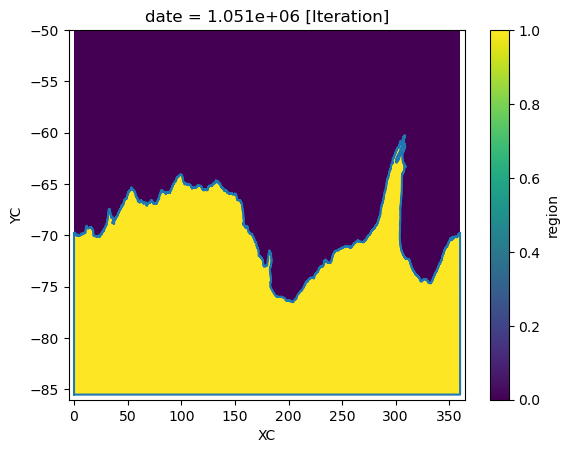

In [12]:
region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c)
plt.ylim(-86, -50)
plt.xlim(-5, 365);

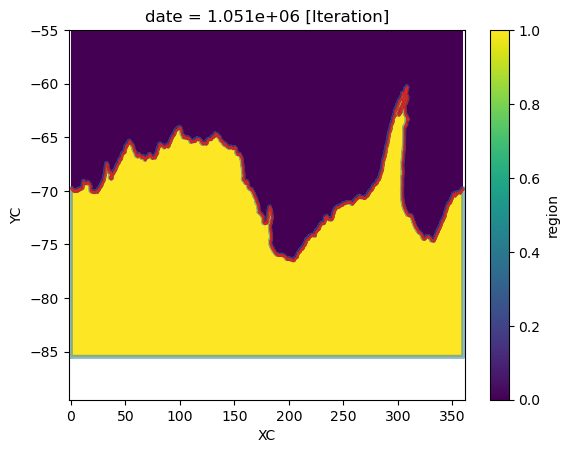

In [16]:
idx_without_border = (
    (region.lons_c != ds_xyouter.XO.min().values) &
    (region.lons_c != ds_xyouter.XO.max().values) &
    (region.lats_c != np.min(region.lats_c))
)

region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c, "C0-", alpha=0.5, markersize=1, lw=3, label="full region boundary")
plt.plot(region.lons_c[idx_without_border], region.lats_c[idx_without_border], "C3.-", lw=0.5, markersize=0.1, label="isobath only (ignoring grid boundaries)")
plt.ylim(-89.5, -55)
plt.xlim(-2, 362);

TypeError: Dimensions of C (2343, 8640) should be one smaller than X(2344) and Y(8641) while using shading='flat' see help(pcolormesh)

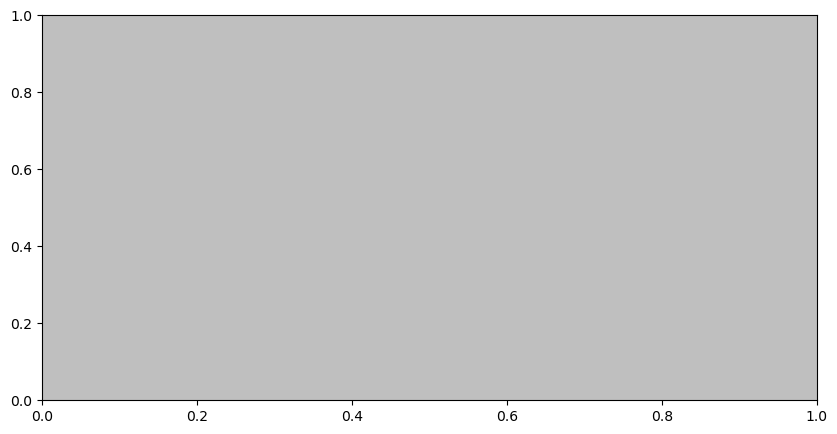

In [19]:
# plot column heat tendency 

dheatdt_dynamics = (ds_xyouter['T_advection_xy']*ds_xyouter['areacello'])
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.).squeeze()

def geoplot(ds, da, *args, **kwargs):
    pc = plt.pcolormesh(
        ds['geolon_c'],
        ds['geolat_c'],
        da,
        *args,
        **kwargs
    )
    return pc

plt.figure(figsize=(10, 5))
plt.subplot(facecolor=(0.75, 0.75, 0.75))
pc = geoplot(
    ds_xyouter,
    dheatdt_dynamics.where(region.mask)*1e-9,
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
pc_dep = geoplot(ds_xyouter, ds_xyouter.deptho.where(~region.mask), cmap="viridis_r", vmin=0, vmax=500)
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(region.lons_uv, region.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left", fontsize=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()

plt.xlim(5, 35)
plt.ylim(50, 70);


In [20]:
dheatdt_dynamics = (ds_xyouter['T_advection_xy']*ds_xyouter['areacello'])
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.).squeeze()
dheatdt_dynamics

<xarray.DataArray (YC: 2343, XC: 8640)> Size: 81MB
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [ 2.0371149e+09,  1.7456070e+09,  1.7217187e+09, ...,
         3.8049264e+08,  9.7741542e+08,  2.6198656e+09],
       [ 1.9577197e+09,  1.1411232e+09,  2.0127590e+09, ...,
        -1.6708261e+08,  8.2943187e+08,  2.3700242e+09],
       [ 3.0819395e+08, -2.9851356e+09, -1.4267428e+09, ...,
        -7.7467533e+08,  7.1430150e+08,  2.0177359e+09]], dtype=float32)
Coordinates:
    date     float32 4B 1.051e+06
  * XC       (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC      (XC) float32 35kB 363.8 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * YC       (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    DYC      (YC) float32 9kB 5.132e+03 999.8 999.8 ... 2.653e+03 2.654e+03
    geolon   (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0 360.0
    geolat   (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03

In [36]:
# From volume integral of horizontal advective tendencies
advective_heating = dheatdt_dynamics.where(region.mask).sum(['XC', 'YC']).squeeze().values # LHS

# From normal-surface integral of diagnosed horizontal heat fluxes
convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i_c[:-1][idx_without_border],
    region.j_c[:-1][idx_without_border],
    utr="T_adx",
    vtr="T_ady",
    layer=None,
    interface=None,
    outname="conv_heat_transport"
)['conv_heat_transport']



/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/sectionate/transports.py:393: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


Text(0, 0.5, 'GW')

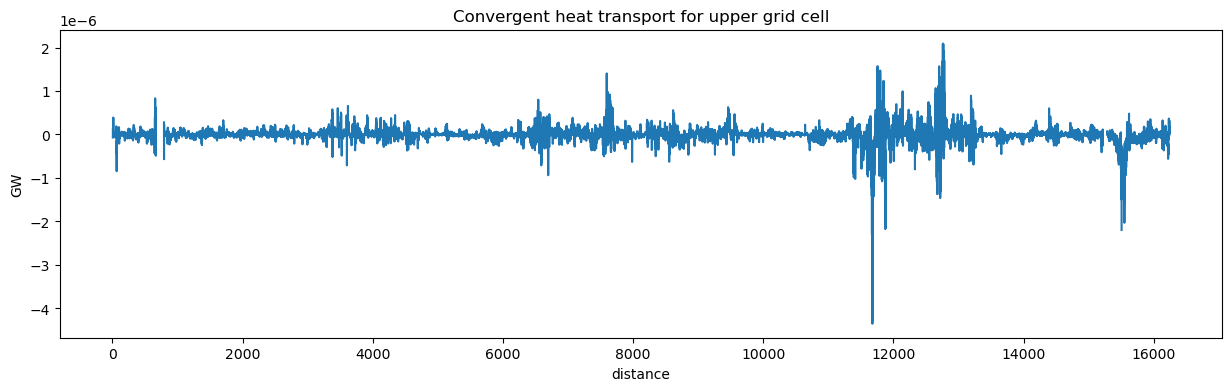

In [38]:
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad((0.75, 0.75, 0.75))
plt.figure(figsize=(15, 4))
da_plot = (
    (convergent_heat_transport*1e-9)
    .where(convergent_heat_transport!=0.)
    .swap_dims({'sect':'distance'})
)
pc = da_plot.plot(x="distance")
plt.title("Convergent heat transport for upper grid cell")
plt.ylabel('GW')

In [23]:
ds_xyouter['T_adx']

<xarray.DataArray 'T_adx' (YC: 2343, XC: 8640)> Size: 81MB
array([[   0.      ,    0.      ,    0.      , ...,    0.      ,
           0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,    0.      ,
           0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,    0.      ,
           0.      ,    0.      ],
       ...,
       [-229.7587  , -179.57185 , -157.3702  , ...,   34.668564,
         -49.18095 , -299.41965 ],
       [-248.7836  , -116.14269 , -217.40103 , ...,   57.93985 ,
         -89.75339 , -316.416   ],
       [ -77.263565,  405.06155 ,  190.33888 , ...,   38.211014,
        -176.68036 , -346.99094 ]], dtype=float32)
Coordinates:
    date     float32 4B 1.051e+06
  * XC       (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC      (XC) float32 35kB 363.8 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * YC       (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    DYC      (YC) float32 9kB 5.132e+03 999.8 999.8 ... 2.653e+03 2.654e+03
    geolon   (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0 360.0
    geolat   (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03